In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import mpl_toolkits as mpl
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

In [4]:
def unnormalised_ground_truth(x1,x2):
    """return the 'ground truth' output for a specific input location x"""
    y = (10 * np.sin(2 * x1 + x2) +
         5 * np.cos(x1 * x2) +
         np.exp(-0.1 * (x1**2 + x2**2)) +
         3 * x1**2 * np.log(1 + x2**2))
    return y

def normalised_ground_truth(x1,x2):
    ys = unnormalised_ground_truth(x1,x2)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s


def generate_dataset(size=500, noise=0.15, split=0.3):
    x1_grid = np.linspace(-3, 3, 500)
    x2_grid = np.linspace(-3, 3, 500)
    x1, x2 = np.meshgrid(x1_grid, x2_grid) # make grid
    x_grid = np.column_stack((x1.flatten(), x2.flatten())) # flatten to pass into function
    ys = normalised_ground_truth(x_grid[:, 0], x_grid[:, 1])
    sample_indices = np.random.choice(len(x_grid), size=size, replace=False) # take random samples

    x_samples = x_grid[sample_indices,:]
    y_samples = ys[sample_indices] + np.random.normal(0, noise, size)

    return train_test_split(x_samples, y_samples, test_size=split, random_state=13)
 


In [4]:
x_tr, x_te, y_tr, y_te = generate_dataset(500, 0.15, 0.3)
x_tr = torch.FloatTensor(x_tr)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [5]:
from GaussianBBB import MeanFieldBNN

In [6]:
bnn_model = MeanFieldBNN(2, [6, 6, 4], 1, noise_std=0.15, prior_var = 0.3)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
    (5): ELU(alpha=1.0)
    (6): MeanFieldLayer()
  )
)


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


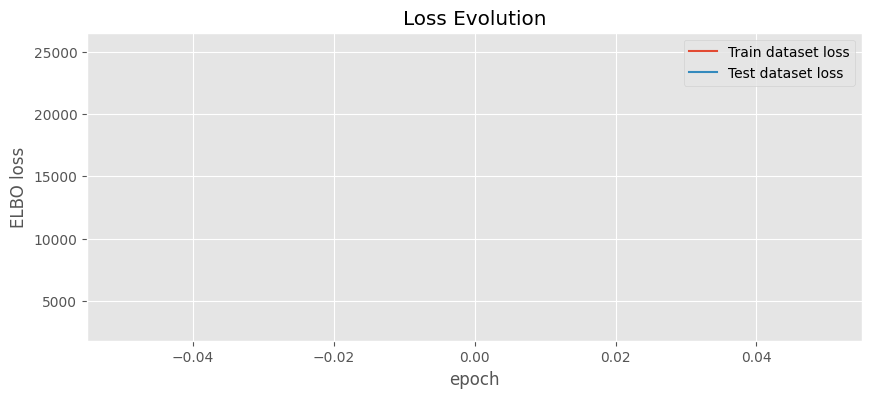

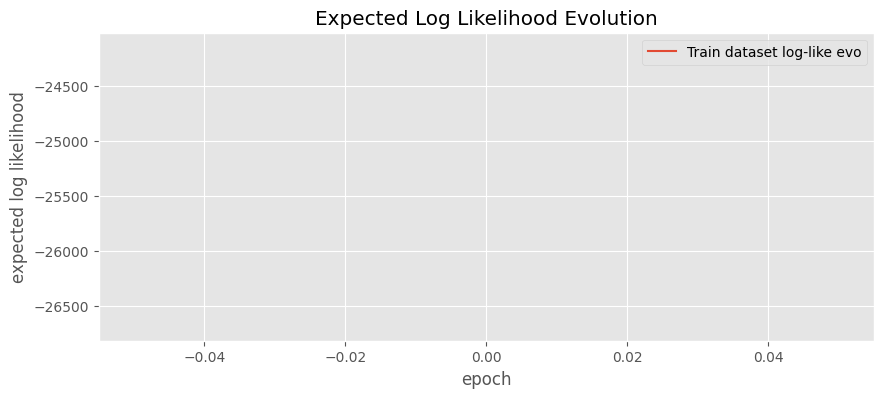

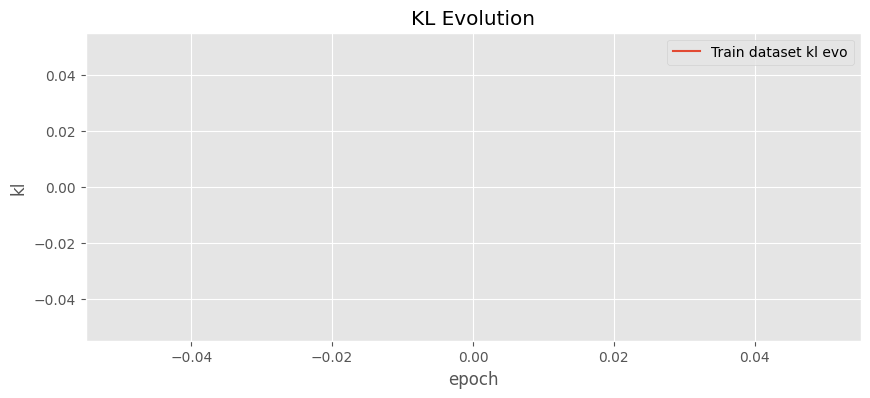

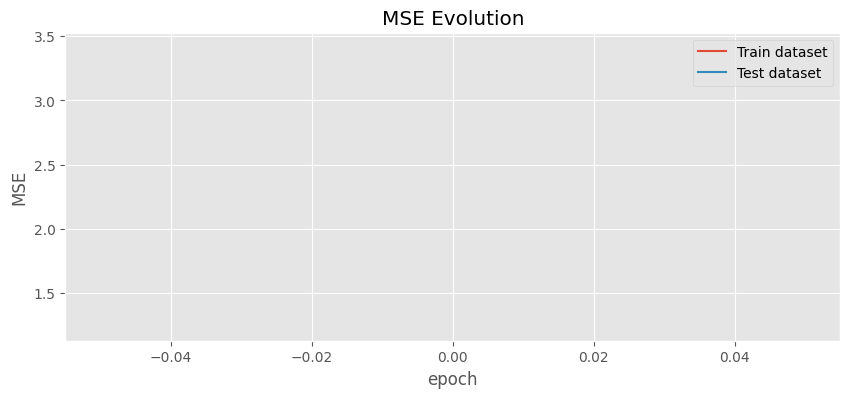

In [7]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(1)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr,num_samples = 1000)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(x_tr), y_tr.unsqueeze(0)).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(bnn_model(x_te), y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

In [61]:
bnn_model = MeanFieldBNN(2, [6, 6, 4], 1, noise_std=0.15, prior_var = 0.3)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
    (5): ELU(alpha=1.0)
    (6): MeanFieldLayer()
  )
)


In [5]:
import torch
from torch import nn

class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=5e-2, prior_var = 1):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
     
        return x @ weights + biases # (num_samples, batch_size, output_dim).








class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

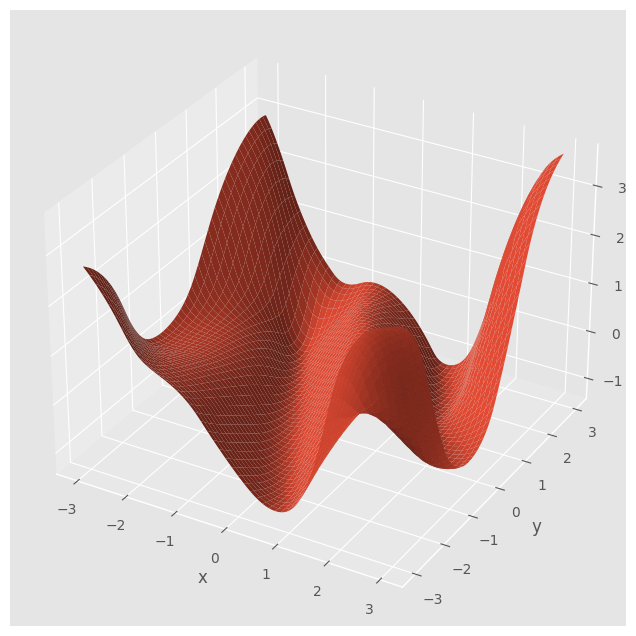

In [ ]:
# Plotting mean prediction
x1_grid = np.arange(-3,3,0.01)
x2_grid = np.arange(-3,3,0.01)
x1, x2 = np.meshgrid(x1_grid, x2_grid) # make grid
x_grid = torch.FloatTensor(np.column_stack((x1.flatten(), x2.flatten()))) 
ys = bnn_model(x_grid, 100).mean(0).detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Z = ys.reshape(x1.shape)
ax.plot_surface(x1,x2,Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

In [12]:
alpha_values = np.arange(0.05, 1.0, 0.05)
num_splits = 1  # Number of train/test splits
num_samples = 100  # BNN posterior samples
epochs = 4000  # Training epochs
mcp_results = {alpha: [] for alpha in alpha_values}  # Store MCP for each alpha

mcp_values = []

for _ in tqdm(range(num_splits)):
    # Generate new dataset
    x_tr, x_te, y_tr, y_te = generate_dataset(size=2000, noise=0.15, split=1/6) 
    y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
    x_tr = torch.FloatTensor(x_tr)
    # Initialize a new BNN
    bnn_model = MeanFieldBNN(2, [6, 6 , 4], 1, noise_std=0.15, prior_var=0.3)
    opt = torch.optim.Adam(bnn_model.parameters(), lr=1e-2)

    # Train the model
    for epoch in range(epochs):
        opt.zero_grad()
        l, ll, kl = bnn_model.loss(x_tr, y_tr, num_samples=10)
        l.backward()
        opt.step()

    # Compute PICP on a large test set
    x1_grid = np.arange(-1,1,0.01)
    x2_grid = np.arange(-1,1,0.01)
    x1, x2 = np.meshgrid(x1_grid, x2_grid) # make grid
    x_grid = torch.FloatTensor(np.column_stack((x1.flatten(), x2.flatten()))) 
    posterior_samples = bnn_model(x_grid, num_samples).detach().numpy()  # Shape: (num_samples, 1000)
    
    true_mean = normalised_ground_truth(x_grid[0],x_grid[1])  # True function values
    noise_std = 0.15  # Known noise std

    for alpha in alpha_values:
        lower_bounds = np.quantile(posterior_samples, alpha / 2, axis=0)
        upper_bounds = np.quantile(posterior_samples, 1 - alpha / 2, axis=0)

        # Compute the coverage probabilities
        coverage_probs = norm.cdf(upper_bounds, loc=true_mean, scale=noise_std) - \
                         norm.cdf(lower_bounds, loc=true_mean, scale=noise_std)

        # Calculate PICP for this alpha and store the result
        picp = np.mean(coverage_probs)
        mcp_results[alpha].append(picp)


for alpha in alpha_values:
    MCP = np.mean(mcp_results[alpha])
    print(f"MCP (1-alpha={1-alpha:.2f}): {MCP:.4f}")

100%|██████████| 1/1 [00:41<00:00, 41.64s/it]

MCP (1-alpha=0.95): 0.1552
MCP (1-alpha=0.90): 0.1305
MCP (1-alpha=0.85): 0.1187
MCP (1-alpha=0.80): 0.1118
MCP (1-alpha=0.75): 0.1009
MCP (1-alpha=0.70): 0.0916
MCP (1-alpha=0.65): 0.0863
MCP (1-alpha=0.60): 0.0800
MCP (1-alpha=0.55): 0.0735
MCP (1-alpha=0.50): 0.0674
MCP (1-alpha=0.45): 0.0616
MCP (1-alpha=0.40): 0.0557
MCP (1-alpha=0.35): 0.0456
MCP (1-alpha=0.30): 0.0392
MCP (1-alpha=0.25): 0.0291
MCP (1-alpha=0.20): 0.0199
MCP (1-alpha=0.15): 0.0140
MCP (1-alpha=0.10): 0.0091
MCP (1-alpha=0.05): 0.0055


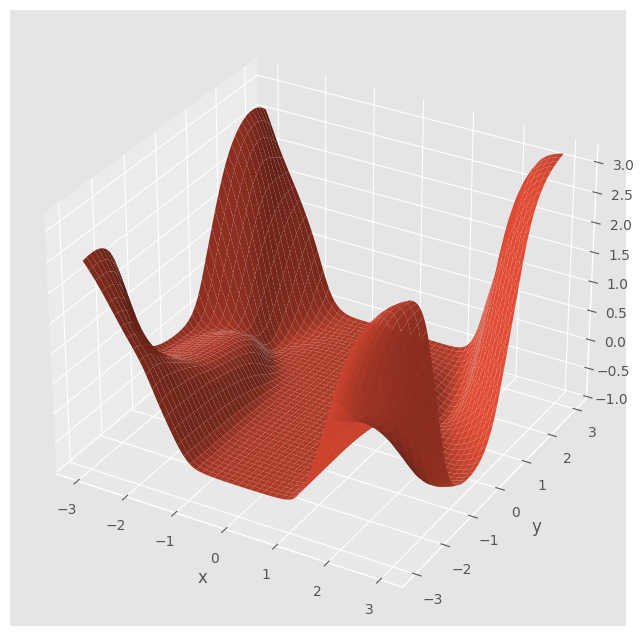

In [13]:
# Plotting mean prediction
x1_grid = np.arange(-3,3,0.01)
x2_grid = np.arange(-3,3,0.01)
x1, x2 = np.meshgrid(x1_grid, x2_grid) # make grid
x_grid = torch.FloatTensor(np.column_stack((x1.flatten(), x2.flatten()))) 
ys = bnn_model(x_grid, 100).mean(0).detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Z = ys.reshape(x1.shape)
ax.plot_surface(x1,x2,Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()